In [1]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/abp_accel.csv'

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import ttest_ind,f_oneway,shapiro
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.metrics import silhouette_score,confusion_matrix,roc_auc_score,accuracy_score,recall_score,precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [3]:
df=pd.read_csv(path)
df.tail()

,timestamp,x,y,z
14595848,2015-06-29 08:29:59.416163,76,1040,-128
14595849,2015-06-29 08:29:59.515527,68,1052,-140
14595850,2015-06-29 08:29:59.614891,112,1024,-132
14595851,2015-06-29 08:29:59.714255,104,1052,-152
14595852,2015-06-29 08:29:59.813619,84,1044,-132


In [4]:
df['timestamp']=pd.to_datetime(df['timestamp'],format='%Y-%m-%d %H:%M:%S.%f')

In [5]:
df['timestamp'].dtype

dtype('<M8[ns]')

In [6]:
df=df.resample('3S',on='timestamp').mean()
df.tail()

,x,y,z
timestamp,,,
2015-06-29 08:29:45,-1.290323,1037.935484,-128.258065
2015-06-29 08:29:48,-35.200000,1036.000000,-124.266667
2015-06-29 08:29:51,-2.266667,1033.466667,-134.266667
2015-06-29 08:29:54,33.733333,1037.866667,-138.666667
2015-06-29 08:29:57,70.206897,1033.103448,-127.586207


In [7]:
df = df.assign(abss = lambda x: abs(df.x+df.y+df.z))

In [8]:
df['rms']=np.sqrt((df**2).mean(axis=1))
df.head()

,x,y,z,abss,rms
timestamp,,,,,
2015-06-12 13:30:00,136.000000,610.344828,844.689655,1591.034483,953.402872
2015-06-12 13:30:03,-88.400000,579.066667,843.200000,1333.866667,841.623326
2015-06-12 13:30:06,-684.400000,412.000000,662.000000,389.600000,554.116305
2015-06-12 13:30:09,-795.741935,343.870968,562.838710,110.967742,519.748430
2015-06-12 13:30:12,-724.933333,390.800000,621.333333,287.200000,535.441857


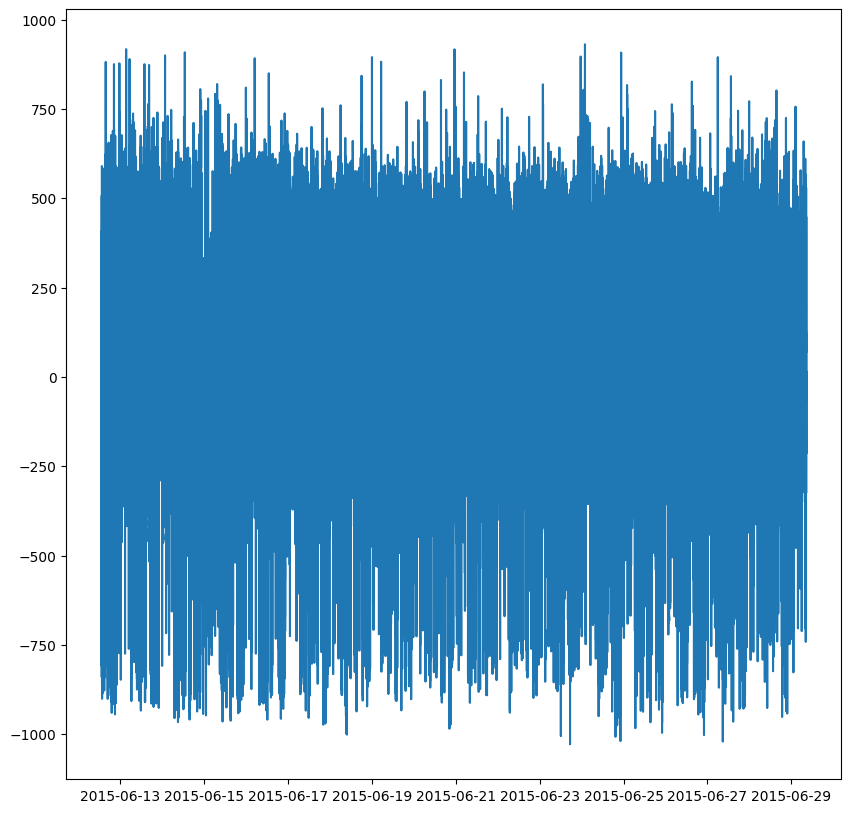

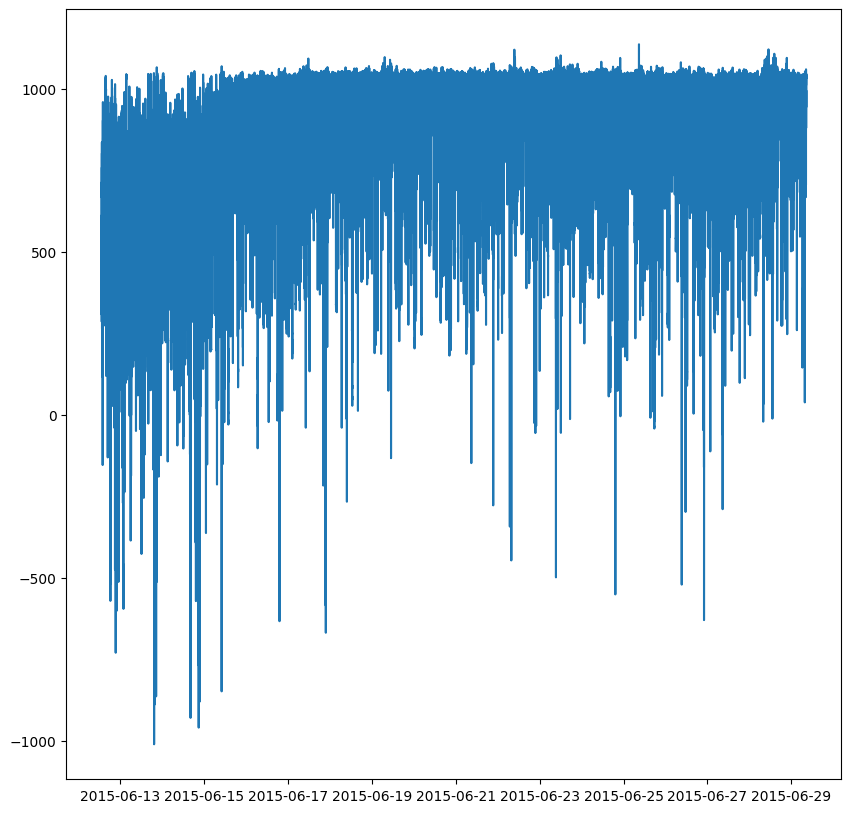

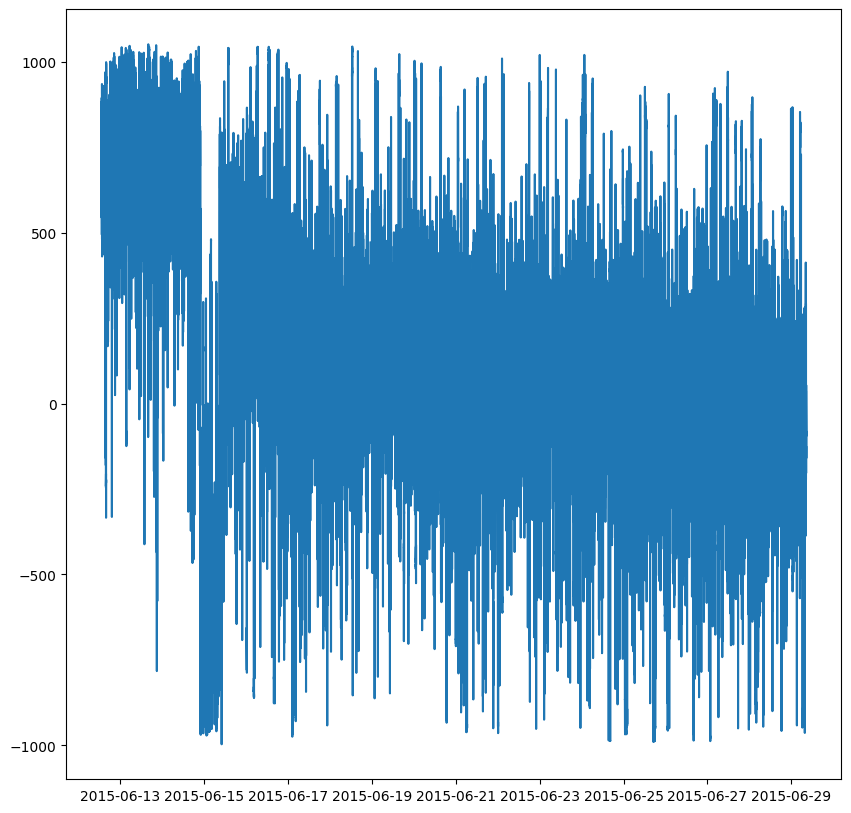

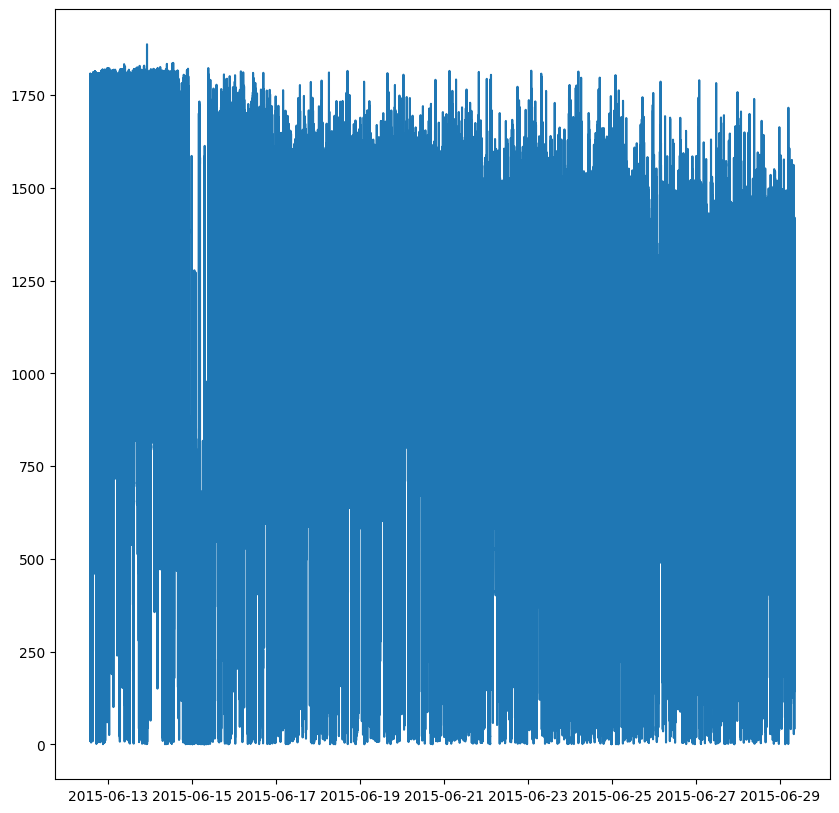

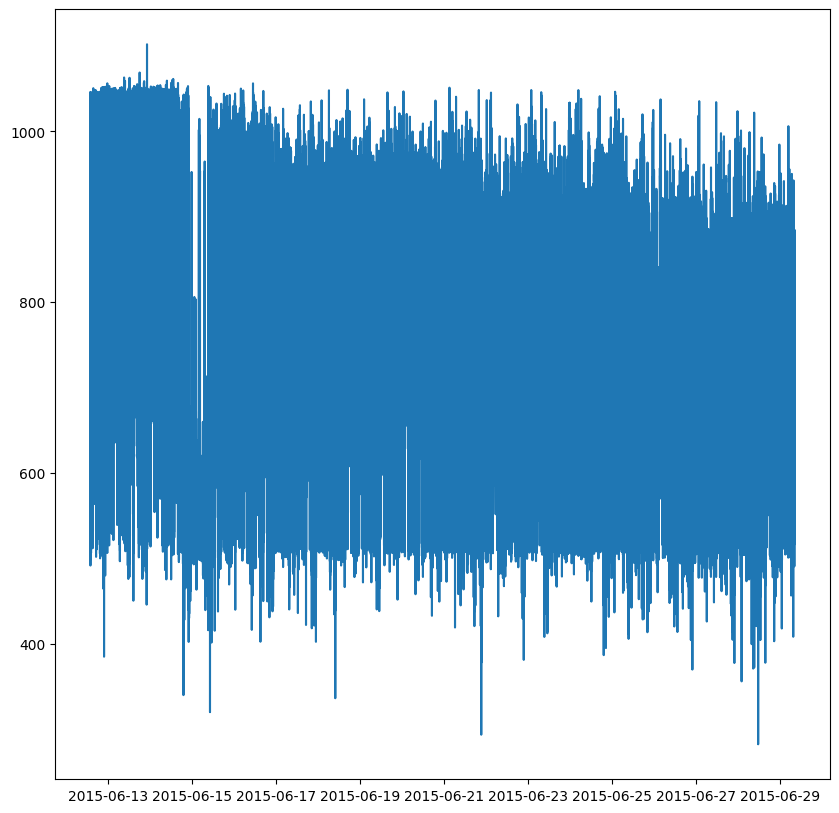

In [9]:
for i in df.columns:
  fig,ax=plt.subplots(figsize=(10,10))
  plt.plot(df.index,df[i])
  plt.show()

In [10]:
df.isnull().sum()

x       0
y       0
z       0
abss    0
rms     0
dtype: int64

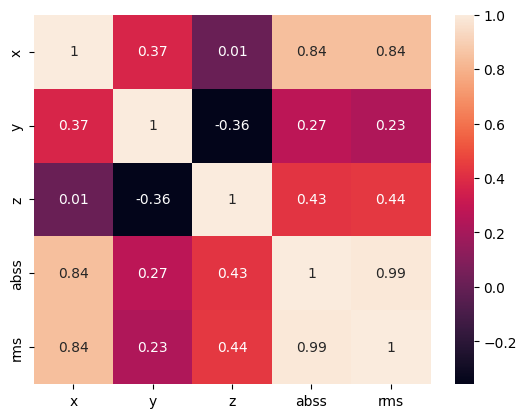

In [11]:
sns.heatmap(data=df.corr(),annot=True);

In [12]:
df[df['x']==100]['y']

timestamp
2015-06-12 13:42:45     600.533333
2015-06-12 14:52:33     758.000000
2015-06-14 08:26:06     827.866667
2015-06-15 09:21:09     972.266667
2015-06-16 14:10:48     960.645161
2015-06-17 07:43:42     955.333333
2015-06-17 10:59:33    1042.266667
2015-06-17 15:51:54    1043.733333
2015-06-17 20:03:09    1035.225806
2015-06-19 03:07:39    1037.466667
2015-06-19 05:50:51    1043.612903
2015-06-20 06:45:39    1041.466667
2015-06-20 07:09:09    1039.866667
2015-06-20 12:48:45     964.266667
2015-06-20 22:12:51     971.200000
2015-06-21 12:57:45    1037.161290
2015-06-21 13:25:39    1024.800000
2015-06-21 23:00:03    1047.096774
2015-06-22 08:32:03    1038.933333
2015-06-22 14:46:09    1017.066667
2015-06-23 05:41:45    1044.000000
2015-06-23 06:59:12    1047.466667
2015-06-23 09:04:30    1042.933333
2015-06-23 09:11:45    1044.400000
2015-06-24 07:26:00    1030.666667
2015-06-24 07:26:12    1030.266667
2015-06-24 18:52:15    1051.483871
2015-06-24 21:52:45    1040.800000
2015-06-25

In [13]:
def check_normality(data):
    test_stat_normality, p_value_normality=shapiro(data)
    print("p value:%.4f" % p_value_normality)
    if p_value_normality <0.05:
        print("Reject null hypothesis >> The data is not normally distributed")
    else:
        print("Fail to reject null hypothesis >> The data is normally distributed")
for i in df.columns:
  check_normality(df[i])

p value:0.0000
Reject null hypothesis >> The data is not normally distributed
p value:0.0000
Reject null hypothesis >> The data is not normally distributed
p value:0.0000
Reject null hypothesis >> The data is not normally distributed
p value:0.0000
Reject null hypothesis >> The data is not normally distributed
p value:0.0000
Reject null hypothesis >> The data is not normally distributed


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


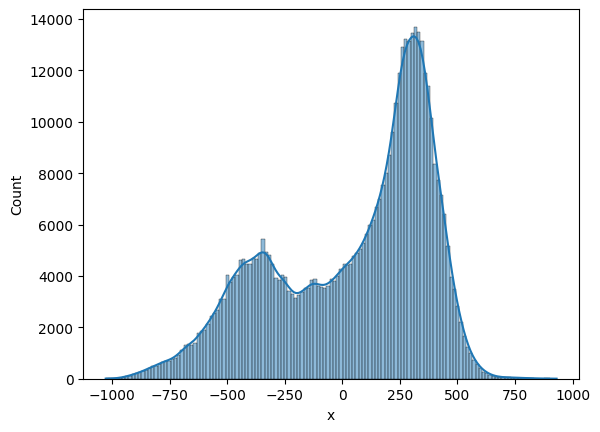

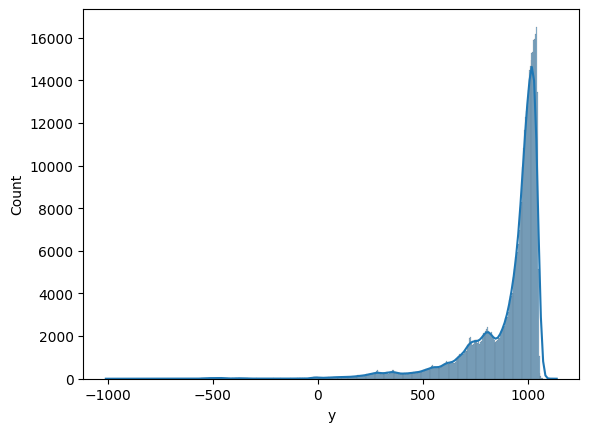

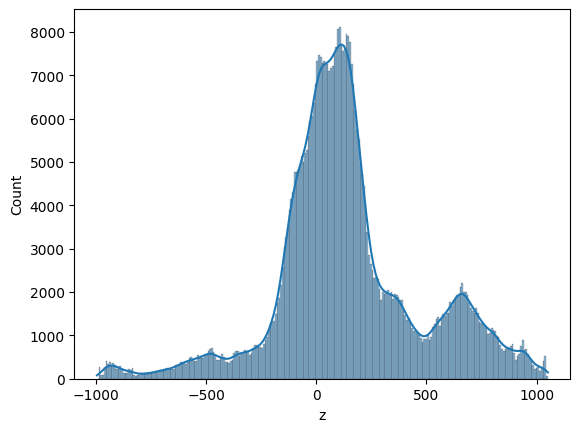

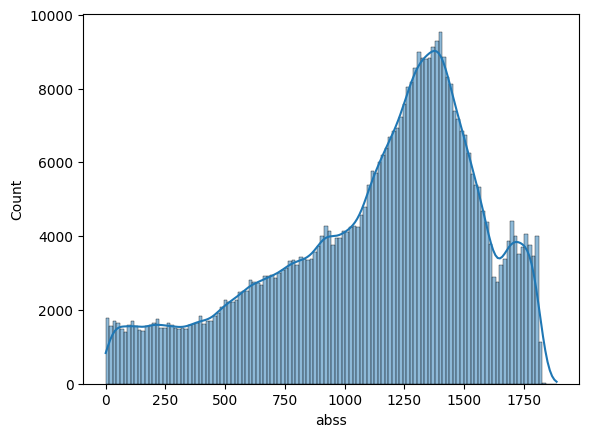

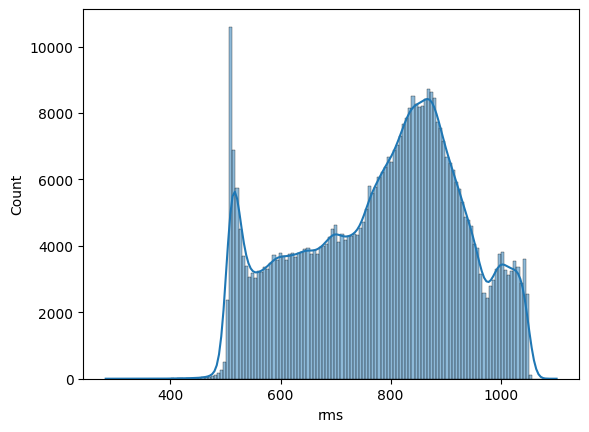

In [14]:
for i in df.columns:
  sns.histplot(data=df,x=df[i],kde=True);
  plt.show()
#It is clearly evident from the graphs,none of the features are normally distributed

In [15]:
#T TEST
#Null Hypothesis:There is no significant difference between accelerometer data along x and y axes
#Alternate Hypothesis:There is significant difference between accelerometer data along x and y axes
#Level of significance:0.05
t_stat,p_value=ttest_ind(df['x'],df['y'])
print('T statistic: ',t_stat)
print('P value: ',p_value)
if p_value<0.05:
  print('We reject the null hypothesis')
else:
  print('We fail to reject the null hypothesis')

T statistic:  -1507.475830144123
P value:  0.0
We reject the null hypothesis


In [16]:
#F Test
#Null Hypothesis:There is no significant difference between accelerometer data along x, y and z axes
#Alternate Hypothesis:There is significant difference between accelerometer data along x, y and z axes
#Level of significance:0.05
f_test, p_val = f_oneway(df['x'], df['y'], df['z'])
print('F statistic: ',f_test)
print('P value: ',p_val)
if p_val<0.05:
  print('We reject the null hypothesis')
else:
  print('We fail to reject the null hypothesis')

F statistic:  1192068.6665737124
P value:  0.0
We reject the null hypothesis


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

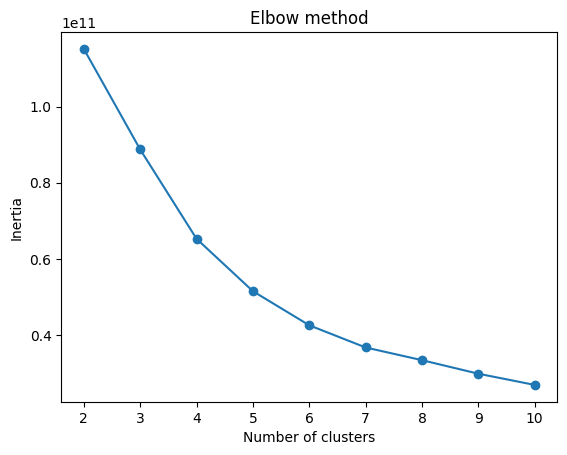

In [17]:
inertias=[]
silhouette_scores=[]
for i in range(2,11):
    # print("printing loop {}".format(i))
    kmeans = KMeans(n_clusters=i, random_state=42).fit(df)
    inertias.append(kmeans.inertia_)
    # silhouette_scores.append(silhouette_score(df, kmeans.labels_, metric='euclidean'))
    # print(silhouette_score(df, kmeans.labels_, metric='euclidean'))
    # print("printing loop after silhouette {} ".format(i))
plt.plot(range(2,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [18]:
for i in range(0,len(silhouette_scores)):
  print("No of Clusters: ",i+2)
  print("Silhouette Score: ",silhouette_scores[i])

In [19]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
df['Cluster']=kmeans.labels_
df.head()

,x,y,z,abss,rms,Cluster
timestamp,,,,,,
2015-06-12 13:30:00,136.000000,610.344828,844.689655,1591.034483,953.402872,3
2015-06-12 13:30:03,-88.400000,579.066667,843.200000,1333.866667,841.623326,2
2015-06-12 13:30:06,-684.400000,412.000000,662.000000,389.600000,554.116305,2
2015-06-12 13:30:09,-795.741935,343.870968,562.838710,110.967742,519.748430,2
2015-06-12 13:30:12,-724.933333,390.800000,621.333333,287.200000,535.441857,2


In [21]:
group=df.groupby('Cluster').median()
group

,x,y,z,abss,rms
Cluster,,,,,
0,247.733333,1012.533333,43.612903,1285.600000,830.287592
1,-373.333333,905.677419,-10.400000,559.733333,584.000677
2,-361.677419,558.133333,731.200000,918.133333,694.912110
3,344.933333,858.666667,484.133333,1630.666667,971.155577


In [22]:
#As evident from the median values:
#3-Rumination
#0-Eating
#2-Standing
#1-Other

In [23]:
X=df.copy()
X=X.drop('Cluster',axis=1)
X.head()

,x,y,z,abss,rms
timestamp,,,,,
2015-06-12 13:30:00,136.000000,610.344828,844.689655,1591.034483,953.402872
2015-06-12 13:30:03,-88.400000,579.066667,843.200000,1333.866667,841.623326
2015-06-12 13:30:06,-684.400000,412.000000,662.000000,389.600000,554.116305
2015-06-12 13:30:09,-795.741935,343.870968,562.838710,110.967742,519.748430
2015-06-12 13:30:12,-724.933333,390.800000,621.333333,287.200000,535.441857


In [24]:
y=df['Cluster']
y.head()

timestamp
2015-06-12 13:30:00    3
2015-06-12 13:30:03    2
2015-06-12 13:30:06    2
2015-06-12 13:30:09    2
2015-06-12 13:30:12    2
Freq: 3S, Name: Cluster, dtype: int32

In [25]:
X= StandardScaler().fit_transform(X)
X=pd.DataFrame(X,columns=['x','y','z','abs','rms'],index=df.index)
X.head()

,x,y,z,abs,rms
timestamp,,,,,
2015-06-12 13:30:00,0.262323,-1.451084,2.118353,1.078224,1.168834
2015-06-12 13:30:03,-0.400575,-1.609818,2.113863,0.488498,0.403610
2015-06-12 13:30:06,-2.161215,-2.457667,1.567712,-1.676855,-1.564615
2015-06-12 13:30:09,-2.490130,-2.803416,1.268832,-2.315802,-1.799892
2015-06-12 13:30:12,-2.280954,-2.565255,1.445140,-1.911674,-1.692457


In [26]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [27]:
model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
model.fit(X_train,y_train)
y_pred=model.predict(X_train)
conf_matrix=confusion_matrix(y_train,y_pred)
accuracy=accuracy_score(y_train,y_pred)
# roc_auc=roc_auc_score(y_train,y_pred, multi_class='ovr',labels=[0,1,2,3])
precision=precision_score(y_train,y_pred, pos_label='positive',
                                           average='micro')
recall=recall_score(y_train,y_pred,
                                           pos_label='positive',
                                           average='micro')
k_folds = KFold(n_splits = 10)
cv_score = cross_val_score(model, X_train, y_train, cv = k_folds)
print('Accuracy for training dataset: ',accuracy)
print('Confusion matrix for training dataset: \n',conf_matrix)
# print('ROC-AUC Score for training dataset: ',roc_auc)
print('Precision for training dataset: ',precision)
print('Recall for training dataset: ',recall)
print('Cross validation score for training dataset: ',cv_score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Accuracy for training dataset:  0.9981744062389224
Confusion matrix for training dataset: 
 [[164787     42     73     37]
 [    87  80392     23      0]
 [     9    113  29309     54]
 [   132      0     48  63414]]
Precision for training dataset:  0.9981744062389224
Recall for training dataset:  0.9981744062389224
Cross validation score for training dataset:  [0.99843436 0.9983162  0.99793218 0.99805034 0.9981685  0.99810942
 0.99778447 0.99784355 0.99784355 0.99793218]


In [28]:
y_pred=model.predict(X_test)
conf_matrix=confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_test,y_pred)
# roc_auc=roc_auc_score(y_train,y_pred, multi_class='ovr',labels=[0,1,2,3])
precision=precision_score(y_test,y_pred, pos_label='positive',
                                           average='micro')
recall=recall_score(y_test,y_pred,
                                           pos_label='positive',
                                           average='micro')
k_folds = KFold(n_splits = 10)
cv_score = cross_val_score(model, X_test, y_test, cv = k_folds)
print('Accuracy for testing dataset: ',accuracy)
print('Confusion matrix for testing dataset: \n',conf_matrix)
# print('ROC-AUC Score for training dataset: ',roc_auc)
print('Precision for testing dataset: ',precision)
print('Recall for testing dataset: ',recall)
print('Cross validation score for testing dataset: ',cv_score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Accuracy for testing dataset:  0.9981527433140336
Confusion matrix for testing dataset: 
 [[70346    20    39    24]
 [   37 34599    11     0]
 [    1    59 12512    17]
 [   37     0    23 27355]]
Precision for testing dataset:  0.9981527433140336
Recall for testing dataset:  0.9981527433140336
Cross validation score for testing dataset:  [0.99744968 0.99738076 0.99703612 0.99758754 0.99786325 0.99751861
 0.99786325 0.99772539 0.99669148 0.99751861]


In [29]:
for i in range(2,6):
  model=KNeighborsClassifier(n_neighbors=i).fit(X_train,y_train)
  y_pred=model.predict(X_train)
  accuracy=accuracy_score(y_train,y_pred)
  print('No of neighbors: ',i)
  print('Accuracy: ',accuracy)
#k=3 has the highest accuracy

No of neighbors:  2
Accuracy:  0.9989690417109772
No of neighbors:  3
Accuracy:  0.9992142266335815
No of neighbors:  4
Accuracy:  0.9988626964433416
No of neighbors:  5
Accuracy:  0.9990281224152192


In [30]:
model=KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)
y_pred=model.predict(X_train)
conf_matrix=confusion_matrix(y_train,y_pred)
accuracy=accuracy_score(y_train,y_pred)
# roc_auc=roc_auc_score(y_train,y_pred, multi_class='ovr',labels=[0,1,2,3])
precision=precision_score(y_train,y_pred, pos_label='positive',
                                           average='micro')
recall=recall_score(y_train,y_pred,
                                           pos_label='positive',
                                           average='micro')
k_folds = KFold(n_splits = 10)
cv_score = cross_val_score(model, X_train, y_train, cv = k_folds)
print('Accuracy for training dataset: ',accuracy)
print('Confusion matrix for training dataset: \n',conf_matrix)
# print('ROC-AUC Score for training dataset: ',roc_auc)
print('Precision for training dataset: ',precision)
print('Recall for training dataset: ',recall)
print('Cross validation score for training dataset: ',cv_score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Accuracy for training dataset:  0.9992142266335815
Confusion matrix for training dataset: 
 [[164848     31     14     46]
 [    40  80441     21      0]
 [     9     26  29437     13]
 [    50      0     16  63528]]
Precision for training dataset:  0.9992142266335815
Recall for training dataset:  0.9992142266335815
Cross validation score for training dataset:  [0.9980208  0.99796172 0.99796172 0.99781401 0.99813896 0.99760723
 0.99754815 0.99825712 0.99799126 0.9981685 ]


In [31]:
y_pred=model.predict(X_test)
conf_matrix=confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_test,y_pred)
# roc_auc=roc_auc_score(y_train,y_pred, multi_class='ovr',labels=[0,1,2,3])
precision=precision_score(y_test,y_pred, pos_label='positive',
                                           average='micro')
recall=recall_score(y_test,y_pred,
                                           pos_label='positive',
                                           average='micro')
k_folds = KFold(n_splits = 10)
cv_score = cross_val_score(model, X_test, y_test, cv = k_folds)
print('Accuracy for testing dataset: ',accuracy)
print('Confusion matrix for testing dataset: \n',conf_matrix)
# print('ROC-AUC Score for training dataset: ',roc_auc)
print('Precision for testing dataset: ',precision)
print('Recall for testing dataset: ',recall)
print('Cross validation score for testing dataset: ',cv_score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Accuracy for testing dataset:  0.9979873173421561
Confusion matrix for testing dataset: 
 [[70310    41    11    67]
 [   51 34586    10     0]
 [   14    27 12538    10]
 [   42     0    19 27354]]
Precision for testing dataset:  0.9979873173421561
Recall for testing dataset:  0.9979873173421561
Cross validation score for testing dataset:  [0.99834574 0.99758754 0.99772539 0.99696719 0.9972429  0.99717397
 0.99731183 0.99793218 0.99682934 0.99793218]


In [32]:
clf = SVC(kernel='linear')

# fitting x samples and y classes
clf.fit(X_train, y_train)
y_pred=clf.predict(X_train)
conf_matrix=confusion_matrix(y_train,y_pred)
accuracy=accuracy_score(y_train,y_pred)
# roc_auc=roc_auc_score(y_train,y_pred, multi_class='ovr',labels=[0,1,2,3])
precision=precision_score(y_train,y_pred, pos_label='positive',
                                           average='micro')
recall=recall_score(y_train,y_pred,
                                           pos_label='positive',
                                           average='micro')
k_folds = KFold(n_splits = 10)
cv_score = cross_val_score(model, X_train, y_train, cv = k_folds)
print('Accuracy for training dataset: ',accuracy)
print('Confusion matrix for training dataset: \n',conf_matrix)
# print('ROC-AUC Score for training dataset: ',roc_auc)
print('Precision for training dataset: ',precision)
print('Recall for training dataset: ',recall)
print('Cross validation score for training dataset: ',cv_score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Accuracy for training dataset:  0.9989306392532199
Confusion matrix for training dataset: 
 [[164800     58      7     74]
 [    34  80462      6      0]
 [    11     70  29394     10]
 [    79      0     13  63502]]
Precision for training dataset:  0.9989306392532199
Recall for training dataset:  0.9989306392532199
Cross validation score for training dataset:  [0.9980208  0.99796172 0.99796172 0.99781401 0.99813896 0.99760723
 0.99754815 0.99825712 0.99799126 0.9981685 ]


In [33]:
y_pred=model.predict(X_test)
conf_matrix=confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_test,y_pred)
# roc_auc=roc_auc_score(y_train,y_pred, multi_class='ovr',labels=[0,1,2,3])
precision=precision_score(y_test,y_pred, pos_label='positive',
                                           average='micro')
recall=recall_score(y_test,y_pred,
                                           pos_label='positive',
                                           average='micro')
k_folds = KFold(n_splits = 10)
cv_score = cross_val_score(model, X_test, y_test, cv = k_folds)
print('Accuracy for testing dataset: ',accuracy)
print('Confusion matrix for testing dataset: \n',conf_matrix)
# print('ROC-AUC Score for training dataset: ',roc_auc)
print('Precision for testing dataset: ',precision)
print('Recall for testing dataset: ',recall)
print('Cross validation score for testing dataset: ',cv_score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Accuracy for testing dataset:  0.9979873173421561
Confusion matrix for testing dataset: 
 [[70310    41    11    67]
 [   51 34586    10     0]
 [   14    27 12538    10]
 [   42     0    19 27354]]
Precision for testing dataset:  0.9979873173421561
Recall for testing dataset:  0.9979873173421561
Cross validation score for testing dataset:  [0.99834574 0.99758754 0.99772539 0.99696719 0.9972429  0.99717397
 0.99731183 0.99793218 0.99682934 0.99793218]


In [34]:
for i in np.arange(0,0.1,0.01):
  clf = DecisionTreeClassifier(ccp_alpha=i)
  clf = clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  accuracy=accuracy_score(y_test,y_pred)
  print('Accuracy: ',accuracy)

Accuracy:  0.9974358974358974
Accuracy:  0.9626826578439481
Accuracy:  0.9468155500413565
Accuracy:  0.9468155500413565
Accuracy:  0.9468155500413565
Accuracy:  0.9468155500413565
Accuracy:  0.9468155500413565
Accuracy:  0.9091122139509237
Accuracy:  0.8731734215605184
Accuracy:  0.8731734215605184


In [35]:
clf=DecisionTreeClassifier().fit(X_train,y_train)
y_pred=model.predict(X_test)
conf_matrix=confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_test,y_pred)
# roc_auc=roc_auc_score(y_train,y_pred, multi_class='ovr',labels=[0,1,2,3])
precision=precision_score(y_test,y_pred, pos_label='positive',
                                           average='micro')
recall=recall_score(y_test,y_pred,
                                           pos_label='positive',
                                           average='micro')
k_folds = KFold(n_splits = 10)
cv_score = cross_val_score(model, X_test, y_test, cv = k_folds)
print('Accuracy for testing dataset: ',accuracy)
print('Confusion matrix for testing dataset: \n',conf_matrix)
# print('ROC-AUC Score for training dataset: ',roc_auc)
print('Precision for testing dataset: ',precision)
print('Recall for testing dataset: ',recall)
print('Cross validation score for testing dataset: ',cv_score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Accuracy for testing dataset:  0.9979873173421561
Confusion matrix for testing dataset: 
 [[70310    41    11    67]
 [   51 34586    10     0]
 [   14    27 12538    10]
 [   42     0    19 27354]]
Precision for testing dataset:  0.9979873173421561
Recall for testing dataset:  0.9979873173421561
Cross validation score for testing dataset:  [0.99834574 0.99758754 0.99772539 0.99696719 0.9972429  0.99717397
 0.99731183 0.99793218 0.99682934 0.99793218]


In [36]:
model=BaggingClassifier(oob_score=True,bootstrap=True).fit(X_train,y_train)
y_pred=model.predict(X_train)
conf_matrix=confusion_matrix(y_train,y_pred)
accuracy=accuracy_score(y_train,y_pred)
# roc_auc=roc_auc_score(y_train,y_pred, multi_class='ovr',labels=[0,1,2,3])
precision=precision_score(y_train,y_pred, pos_label='positive',
                                           average='micro')
recall=recall_score(y_train,y_pred,
                                           pos_label='positive',
                                           average='micro')
k_folds = KFold(n_splits = 10)
cv_score = cross_val_score(model, X_train, y_train, cv = k_folds)
print('Accuracy for training dataset: ',accuracy)
print('Confusion matrix for training dataset: \n',conf_matrix)
# print('ROC-AUC Score for training dataset: ',roc_auc)
print('Precision for training dataset: ',precision)
print('Recall for training dataset: ',recall)
print('Cross validation score for training dataset: ',cv_score)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-package

Accuracy for training dataset:  0.9998582063098193
Confusion matrix for training dataset: 
 [[164930      2      1      6]
 [     8  80491      3      0]
 [     4      7  29474      0]
 [    12      0      5  63577]]
Precision for training dataset:  0.9998582063098193
Recall for training dataset:  0.9998582063098193
Cross validation score for training dataset:  [0.99807988 0.99805034 0.99805034 0.99766631 0.99843436 0.99748907
 0.99810942 0.99796172 0.99796172 0.99822758]


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


In [37]:
y_pred=model.predict(X_test)
conf_matrix=confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_test,y_pred)
# roc_auc=roc_auc_score(y_train,y_pred, multi_class='ovr',labels=[0,1,2,3])
precision=precision_score(y_test,y_pred, pos_label='positive',
                                           average='micro')
recall=recall_score(y_test,y_pred,
                                           pos_label='positive',
                                           average='micro')
k_folds = KFold(n_splits = 10)
cv_score = cross_val_score(model, X_test, y_test, cv = k_folds)
print('Accuracy for testing dataset: ',accuracy)
print('Confusion matrix for testing dataset: \n',conf_matrix)
# print('ROC-AUC Score for training dataset: ',roc_auc)
print('Precision for testing dataset: ',precision)
print('Recall for testing dataset: ',recall)
print('Cross validation score for testing dataset: ',cv_score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/usr/local/lib/python3.10/dist-package

Accuracy for testing dataset:  0.9979873173421561
Confusion matrix for testing dataset: 
 [[70333    33     8    55]
 [   32 34599    16     0]
 [   15    34 12524    16]
 [   61     0    22 27332]]
Precision for testing dataset:  0.9979873173421561
Recall for testing dataset:  0.9979873173421561
Cross validation score for testing dataset:  [0.99772539 0.99765647 0.99689826 0.99758754 0.99696719 0.99772539
 0.99696719 0.9980011  0.99655363 0.99744968]


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


In [38]:
for i in np.arange(0.01,0.1,0.01):
  model=RandomForestClassifier(ccp_alpha=i,oob_score=True).fit(X_train,y_train)
  y_pred=model.predict(X_train)
  accuracy=accuracy_score(y_train,y_pred)
  print('Accuracy : ',accuracy)

Accuracy :  0.9666518964906061
Accuracy :  0.9645308992083186
Accuracy :  0.9518787663948954
Accuracy :  0.925265863169089
Accuracy :  0.951479971641262
Accuracy :  0.9151039820394659
Accuracy :  0.8745332624364882
Accuracy :  0.8741196975067943
Accuracy :  0.8740635708377644


In [39]:
model=RandomForestClassifier(ccp_alpha=0.01,oob_score=True).fit(X_train,y_train)
y_pred=model.predict(X_train)
conf_matrix=confusion_matrix(y_train,y_pred)
accuracy=accuracy_score(y_train,y_pred)
# roc_auc=roc_auc_score(y_train,y_pred, multi_class='ovr',labels=[0,1,2,3])
precision=precision_score(y_train,y_pred, pos_label='positive',
                                           average='micro')
recall=recall_score(y_train,y_pred,
                                           pos_label='positive',
                                           average='micro')
k_folds = KFold(n_splits = 10)
cv_score = cross_val_score(model, X_train, y_train, cv = k_folds)
print('Accuracy for training dataset: ',accuracy)
print('Confusion matrix for training dataset: \n',conf_matrix)
# print('ROC-AUC Score for training dataset: ',roc_auc)
print('Precision for training dataset: ',precision)
print('Recall for training dataset: ',recall)
print('Cross validation score for training dataset: ',cv_score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Accuracy for training dataset:  0.9662176533144275
Confusion matrix for training dataset: 
 [[160727   2105   1028   1079]
 [  2057  77673    757     15]
 [   192    559  28441    293]
 [  2885      0    466  60243]]
Precision for training dataset:  0.9662176533144275
Recall for training dataset:  0.9662176533144275
Cross validation score for training dataset:  [0.9664717  0.96936665 0.96877585 0.96644216 0.96933711 0.96697389
 0.96697389 0.96833274 0.96750561 0.96889401]


In [40]:
y_pred=model.predict(X_test)
conf_matrix=confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_test,y_pred)
# roc_auc=roc_auc_score(y_train,y_pred, multi_class='ovr',labels=[0,1,2,3])
precision=precision_score(y_test,y_pred, pos_label='positive',
                                           average='micro')
recall=recall_score(y_test,y_pred,
                                           pos_label='positive',
                                           average='micro')
k_folds = KFold(n_splits = 10)
cv_score = cross_val_score(model, X_test, y_test, cv = k_folds)
print('Accuracy for testing dataset: ',accuracy)
print('Confusion matrix for testing dataset: \n',conf_matrix)
# print('ROC-AUC Score for training dataset: ',roc_auc)
print('Precision for testing dataset: ',precision)
print('Recall for testing dataset: ',recall)
print('Cross validation score for testing dataset: ',cv_score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Accuracy for testing dataset:  0.9656258615936035
Confusion matrix for testing dataset: 
 [[68552   917   469   491]
 [  871 33455   313     8]
 [   86   238 12157   108]
 [ 1267     0   219 25929]]
Precision for testing dataset:  0.9656258615936035
Recall for testing dataset:  0.9656258615936035
Cross validation score for testing dataset:  [0.96967191 0.96850014 0.96443342 0.96719052 0.96787979 0.96622553
 0.96608768 0.96719052 0.96401985 0.96787979]


In [41]:
for i in range(1,10):
  model=AdaBoostClassifier(learning_rate=i).fit(X_train,y_train)
  y_pred=model.predict(X_train)
  accuracy=accuracy_score(y_train,y_pred)
  print('Accuracy : ',accuracy)

Accuracy :  0.7111603450313128
Accuracy :  0.528612785064398
Accuracy :  0.577132813423136
Accuracy :  0.6556953798889282
Accuracy :  0.7331354129741227
Accuracy :  0.7342461302138722
Accuracy :  0.6813423136003781
Accuracy :  0.5658218125960062
Accuracy :  0.7303999763677183


In [42]:
model=AdaBoostClassifier(learning_rate=6).fit(X_train,y_train)
y_pred=model.predict(X_train)
conf_matrix=confusion_matrix(y_train,y_pred)
accuracy=accuracy_score(y_train,y_pred)
# roc_auc=roc_auc_score(y_train,y_pred, multi_class='ovr',labels=[0,1,2,3])
precision=precision_score(y_train,y_pred, pos_label='positive',
                                           average='micro')
recall=recall_score(y_train,y_pred,
                                           pos_label='positive',
                                           average='micro')
k_folds = KFold(n_splits = 10)
cv_score = cross_val_score(model, X_train, y_train, cv = k_folds)
print('Accuracy for training dataset: ',accuracy)
print('Confusion matrix for training dataset: \n',conf_matrix)
# print('ROC-AUC Score for training dataset: ',roc_auc)
print('Precision for training dataset: ',precision)
print('Recall for training dataset: ',recall)
print('Cross validation score for training dataset: ',cv_score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Accuracy for training dataset:  0.7342461302138722
Confusion matrix for training dataset: 
 [[151561      0   4308   9070]
 [ 66365   9262   4853     22]
 [    58      6  29347     74]
 [    18      0   5189  58387]]
Precision for training dataset:  0.7342461302138722
Recall for training dataset:  0.7342461302138722
Cross validation score for training dataset:  [0.71106582 0.71029777 0.70554177 0.73463902 0.7348458  0.64894246
 0.5742349  0.70134704 0.73387097 0.66879357]


In [43]:
y_pred=model.predict(X_test)
conf_matrix=confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_test,y_pred)
# roc_auc=roc_auc_score(y_train,y_pred, multi_class='ovr',labels=[0,1,2,3])
precision=precision_score(y_test,y_pred, pos_label='positive',
                                           average='micro')
recall=recall_score(y_test,y_pred,
                                           pos_label='positive',
                                           average='micro')
k_folds = KFold(n_splits = 10)
cv_score = cross_val_score(model, X_test, y_test, cv = k_folds)
print('Accuracy for testing dataset: ',accuracy)
print('Confusion matrix for testing dataset: \n',conf_matrix)
# print('ROC-AUC Score for training dataset: ',roc_auc)
print('Precision for testing dataset: ',precision)
print('Recall for testing dataset: ',recall)
print('Cross validation score for testing dataset: ',cv_score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Accuracy for testing dataset:  0.7329128756548111
Confusion matrix for testing dataset: 
 [[64626     0  1869  3934]
 [28644  3940  2052    11]
 [   22     0 12532    35]
 [    2     0  2180 25233]]
Precision for testing dataset:  0.7329128756548111
Recall for testing dataset:  0.7329128756548111
Cross validation score for testing dataset:  [0.64612628 0.63950924 0.88247863 0.82926661 0.77639923 0.79432037
 0.63406396 0.77881169 0.67218087 0.82037497]


In [46]:
model=GradientBoostingClassifier(ccp_alpha=0.01).fit(X_train,y_train)
y_pred=model.predict(X_train)
conf_matrix=confusion_matrix(y_train,y_pred)
accuracy=accuracy_score(y_train,y_pred)
# roc_auc=roc_auc_score(y_train,y_pred, multi_class='ovr',labels=[0,1,2,3])
precision=precision_score(y_train,y_pred, pos_label='positive',
                                           average='micro')
recall=recall_score(y_train,y_pred,
                                           pos_label='positive',
                                           average='micro')
k_folds = KFold(n_splits = 10)
cv_score = cross_val_score(model, X_train, y_train, cv = k_folds)
print('Accuracy for training dataset: ',accuracy)
print('Confusion matrix for training dataset: \n',conf_matrix)
# print('ROC-AUC Score for training dataset: ',roc_auc)
print('Precision for training dataset: ',precision)
print('Recall for training dataset: ',recall)
print('Cross validation score for training dataset: ',cv_score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Accuracy for training dataset:  0.9560941746425617
Confusion matrix for training dataset: 
 [[161478   1598    651   1212]
 [  2367  77948    166     21]
 [   762   1047  27595     81]
 [  6414      0    544  56636]]
Precision for training dataset:  0.9560941746425617
Recall for training dataset:  0.9560941746425617
Cross validation score for training dataset:  [0.95749143 0.95604396 0.9565166  0.95409429 0.95846626 0.95610304
 0.95459648 0.95601442 0.95421245 0.9563689 ]


In [47]:
y_pred=model.predict(X_test)
conf_matrix=confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_test,y_pred)
# roc_auc=roc_auc_score(y_train,y_pred, multi_class='ovr',labels=[0,1,2,3])
precision=precision_score(y_test,y_pred, pos_label='positive',
                                           average='micro')
recall=recall_score(y_test,y_pred,
                                           pos_label='positive',
                                           average='micro')
k_folds = KFold(n_splits = 10)
cv_score = cross_val_score(model, X_test, y_test, cv = k_folds)
print('Accuracy for testing dataset: ',accuracy)
print('Confusion matrix for testing dataset: \n',conf_matrix)
# print('ROC-AUC Score for training dataset: ',roc_auc)
print('Precision for testing dataset: ',precision)
print('Recall for testing dataset: ',recall)
print('Cross validation score for testing dataset: ',cv_score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Accuracy for testing dataset:  0.9559966914805624
Confusion matrix for testing dataset: 
 [[68930   671   290   538]
 [ 1034 33541    63     9]
 [  304   460 11790    35]
 [ 2738     0   242 24435]]
Precision for testing dataset:  0.9559966914805624
Recall for testing dataset:  0.9559966914805624
Cross validation score for testing dataset:  [0.95533499 0.95754067 0.9556107  0.95499035 0.95574855 0.95623104
 0.95554177 0.95664461 0.95202647 0.95574855]
